In [17]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import plotly
import numpy as np
import seaborn as sns
import calendar
import pandasql as pdsql

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import itertools

# Gradient Boosting Classifier

This is an application of Gradient boosting for multiclassification of an unbalanced data set

data sets: Insight_Train_DC.csv, Insight_Test_DC.csv'



### functions

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data

In [42]:


df_train=pd.read_csv('Insight_Train_DC.csv')
df_train=pd.DataFrame(df_train)

df_train[df_train.isnull()==True] = 0

m = df_train.shape[0]
n = df_train.shape[1]

X = df_train.iloc[:,0:n-1]
Y = df_train.iloc[:,n-1]

Xtrain,Xtest, Ytrain,Ytest = train_test_split(X, Y, test_size = 0.3, random_state = 30)

## Model

0.947162426614
[ 0.00424377  0.98342487  0.00693335  0.00539802]
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       422
          1       0.89      0.66      0.76        50
          2       0.81      0.90      0.85        39

avg / total       0.95      0.95      0.94       511

Confusion matrix, without normalization
[[416   2   4]
 [ 13  33   4]
 [  2   2  35]]


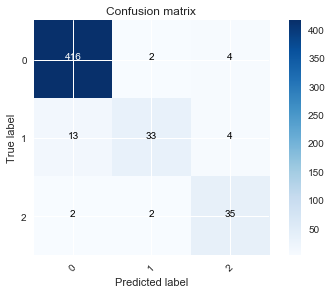

In [43]:
params = {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 2,
         'learning_rate': 0.01}
model_gb = GradientBoostingClassifier(**params)
model_gb.fit(Xtrain,Ytrain)
Y_pred = model_gb.predict(Xtest)

print(model_gb.score(Xtest, Ytest))
print(model_gb.predict_proba(Xtest)[0])
print(classification_report(Ytest,Y_pred, target_names=['0','1','2','3']))

cm = metrics.confusion_matrix(Ytest, Y_pred)
plot_confusion_matrix(cm, ['0','1','2'])

## Learning curve

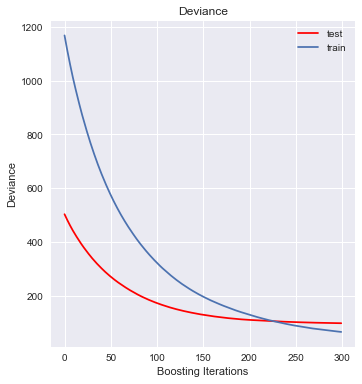

In [295]:
ne = len(model_gb.estimators_)
test_error = np.empty(ne)

for i,pred in enumerate(model_gb.staged_decision_function(Xtest)):
    test_error[i] = model_gb.loss_(np.array(Ytest), pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(ne), test_error, '-r', label='test')
plt.plot(np.arange(ne), model_gb.train_score_, label='train')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Gradient boosting with weights

In [30]:
a = pd.DataFrame(Ytrain)
a = a.iloc[:,0].value_counts()
print('number of observations/class')
print(a)

number of observations/class
1.0    986
2.0    104
3.0     98
0.0      2
Name: NSP, dtype: int64


In [31]:
def sample_weights(Y):
    sample_weights = np.empty(len(df))

    w = pd.DataFrame(Y)
    a = np.array(w.iloc[:,0].value_counts())

    w[w.NSP==1] = 0.25/a[0]
    w[w.NSP==2] = 0.25/a[1]
    w[w.NSP==3]= 0.25/a[2]
    w[w.NSP==0] = 0.25/a[3]

    return np.array(w)*1000

sw = sample_weights(Ytrain)

## Model 


/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/sklearn/ensemble/gradient_boosting.py:978: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.929549902153
[  6.14380223e-04   9.95298192e-01   3.09199815e-03   9.95429460e-04]
             precision    recall  f1-score   support

          0       0.97      0.96      0.96       422
          1       0.70      0.70      0.70        50
          2       0.81      0.90      0.85        39

avg / total       0.93      0.93      0.93       511

Confusion matrix, without normalization
[[405  13   4]
 [ 11  35   4]
 [  2   2  35]]


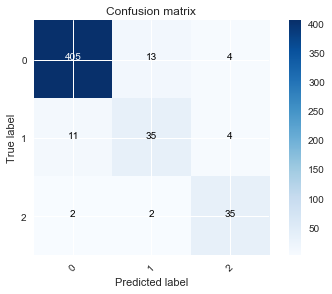

In [36]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
         'learning_rate': 0.01}
model_gb = GradientBoostingClassifier(**params)
#model_gb = GradientBoostingClassifier(n_estimators=1000)
model_gb.fit(Xtrain,Ytrain, sample_weight= sw)
Y_pred = model_gb.predict(Xtest)
print(model_gb.score(Xtest, Ytest))
print(model_gb.predict_proba(Xtest)[0])
print(classification_report(Ytest,Y_pred, target_names=['0','1','2','3']))
cm = metrics.confusion_matrix(Ytest, Y_pred)
plot_confusion_matrix(cm, ['0','1','2'])

## Feature importance

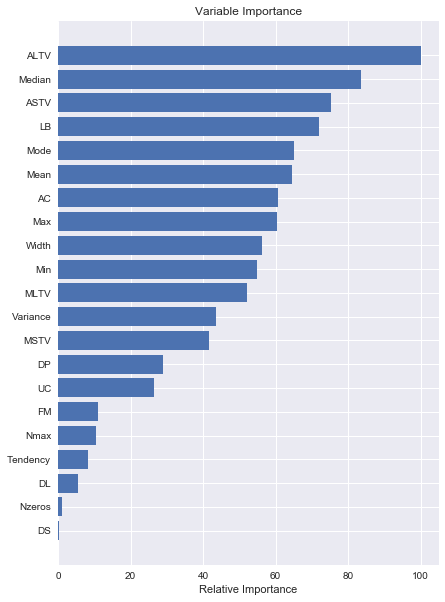

In [38]:
feature_importance = model_gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Learning curve

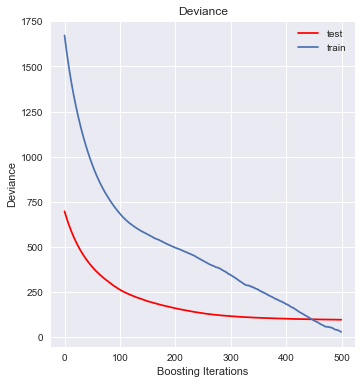

In [33]:
ne = len(model_gb.estimators_)
test_error = np.empty(ne)

for i,pred in enumerate(model_gb.staged_decision_function(Xtest)):
    test_error[i] = model_gb.loss_(np.array(Ytest), pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(ne), test_error, '-r', label='test')
plt.plot(np.arange(ne), model_gb.train_score_, label='train')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Feature importance

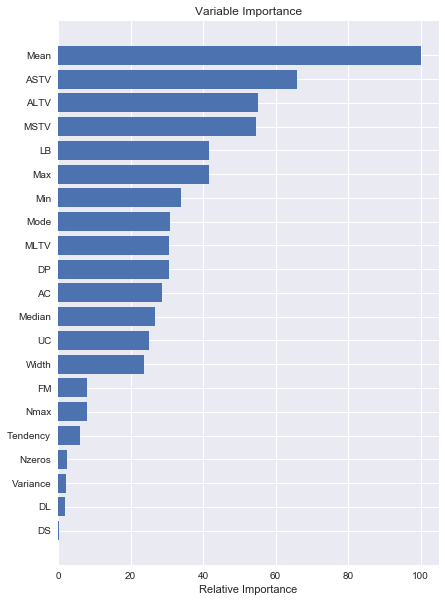

In [28]:
feature_importance = model_gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Test  predictions

In [40]:
df=pd.read_csv('Insight_Test_DC.csv')
df=pd.DataFrame(df)

df[df.isnull()==True] = 0

m = df.shape[0]
n = df.shape[1]

X = df.iloc[:,0:n-1]
Y = df.iloc[:,n-1]

Y_pred = model_gb.predict(X)



0.901639344262
Confusion matrix, without normalization
[[225  21   1]
 [ 14 125   2]
 [  0   4  35]]


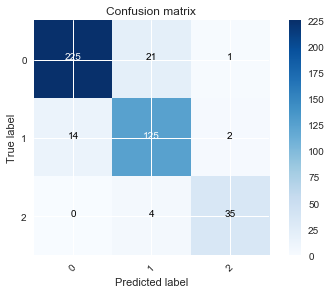

In [41]:
print(model_gb.score(X,Y))
cm = metrics.confusion_matrix(Y, Y_pred)
plot_confusion_matrix(cm, ['0','1','2'])